In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pickle

from kmer_utils.kmer_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
merged_data = pd.read_csv('../data/merged_data.csv')


In [9]:
specs = merged_data['species'].unique()
print(f"Number of species: {len(specs)}")
specs_new = ['Aggregatibacter actinomycetemcomitans']
for spec in specs:
    if not 'Aggregatibacter actinomycetemcomitans' in spec:
        specs_new.append(spec)
        
print(f"Number of species: {len(specs_new)}")
for spec in specs_new:
    print(f". {spec}")

Number of species: 2257
Number of species: 33
. Aggregatibacter actinomycetemcomitans
. Achromobacter xylosoxidans SOLR10
. Acinetobacter baumannii AB5075-UW
. Borrelia burgdorferi B31
. Burkholderia pseudomallei K96243
. Campylobacter jejuni subsp. jejuni 81-176
. Enterococcus faecalis OG1RF
. Escherichia coli EPEC 0127:H6 E2348/69
. Escherichia coli ETEC H10407
. Escherichia coli UPEC 536
. Francisella tularensis subsp. holarctica FSC200
. Haemophilus influenzae 86-028NP
. Helicobacter pylori G27
. Helicobacter pylori G28
. Helicobacter pylori J99
. Klebsiella pneumoniae subsp. pneumoniae MGH 78578
. Legionella pneumophila subsp. pneumophila Philadelphia 1
. Listeria monocytogenes EGD-e
. Mycobacterium tuberculosis H37Ra
. Neisseria gonorrhoeae FA 1090
. Neisseria meningitidis serogroup C FAM18
. Pseudomonas aeruginosa PAO1
. Salmonella enterica subsp. enterica serovar Typhimurium SL1344
. Shigella flexneri 5a str. M90T
. Staphylococcus aureus MRSA252
. Staphylococcus aureus MSSA476


## K-mer counting
Count k-mers for each species in each condition and normalize their respective counts per unit of TPM based on their control value.
Outliers with especiially high counts might indicate a realation to that specififc stress for that specific condition.

In [15]:

#{species_id : [six_mer_counts,basecounts]}
species_full_count_data = {}


In [16]:
K = 3

In [17]:
'''
WARNING this is highly unoptimized and will take ages to run

May be easier to just send the pickle file
'''




kmers_per_tpm_total = {}

for spec_id in tqdm(merged_data['species_id'].unique()):
    species_df = merged_data[merged_data['species_id'] == spec_id]

    stress_conditions = list(set([col.split("_")[0] for col in species_df.columns if 'tpm' in col]))

    kmers_per_tpm = {condition : {} for condition in stress_conditions}
    species_df.apply(lambda row: update_kmer_counts_per_tpm(kmers_per_tpm, row, K), axis=1)

    kmers_per_tpm = pd.DataFrame(kmers_per_tpm)
    kmers_per_tpm = kmers_per_tpm.div(kmers_per_tpm['ctrl'], axis=0) # normalize on ctrl

    kmers_per_tpm = kmers_per_tpm[kmers_per_tpm.sum(axis=1) > 0]
    
    kmers_per_tpm = kmers_per_tpm[~kmers_per_tpm.index.str.contains('N')]

    kmers_per_tpm_total[spec_id] = kmers_per_tpm
    
    


  0%|          | 0/32 [00:00<?, ?it/s]

In [18]:
pickle.dump(kmers_per_tpm_total, open(f'../data/kmers_per_tpm_total_{K}.pkl', 'wb'))

In [5]:
kmers_per_tpm_total = pickle.load(open(f'../data/kmers_per_tpm_total_{K}.pkl', 'rb'))

In [19]:
#pick one below
merged_data['species_id'].unique()

array(['ACHX', 'ACIB', 'AGGA', 'BBURG', 'BURK', 'Campy', 'ENTFA', 'EPEC',
       'ETEC', 'UPEC', 'FRAT', 'HINF', 'HPG27', 'HPJ99', 'KLEBS', 'LEGIP',
       'Listeria', 'MTB', 'NGON', 'NMEN', 'PSEUDO', 'SALMT', 'SHIF',
       'MRSA', 'MSSA', 'SEPI', 'STAGA', 'STRPN', 'SPYO', 'SSUIS',
       'Vibrio', 'YPSTB'], dtype=object)

In [20]:
SpecId = 'AGGA'
best_kmers = {}

for specId in merged_data['species_id'].unique():
    spec_kmers = kmers_per_tpm_total[specId]
    best_kmers[specId] = {}
    for col in spec_kmers.columns:
        if spec_kmers[col].sum() > 0:
            best_kmers[specId][col] = spec_kmers[col].sort_values(ascending=False).index[0]

pickle.dump(best_kmers, open(f'../data/best_{K}_mers.pkl', 'wb'))

print(best_kmers)


{'ACHX': {'mig': 'CTA', 'bs': 'TTT', 'vic': 'ATT', 'li': 'TTA', 'oxs': 'TAA', 'ns': 'AAA', 'nd': 'GAG', 'sp': 'CTC', 'oss': 'TTT', 'as': 'GGG', 'ctrl': 'CCT', 'tm': 'CGA'}, 'ACIB': {'mig': 'CCC', 'bs': 'CGC', 'vic': 'CCC', 'li': 'ATA', 'oxs': 'ATA', 'ns': 'GGG', 'nd': 'CCC', 'sp': 'CCC', 'oss': 'ATA', 'as': 'ATA', 'ctrl': 'CAG', 'tm': 'CCC'}, 'AGGA': {'mig': 'TCT', 'bs': 'CCG', 'vic': 'GAG', 'li': 'ATA', 'oxs': 'ATA', 'ns': 'ATA', 'nd': 'CCT', 'sp': 'CTC', 'oss': 'CTC', 'as': 'CTC', 'ctrl': 'AAA', 'tm': 'CCC'}, 'BBURG': {'mig': 'CAC', 'vic': 'CGC', 'li': 'TAC', 'oxs': 'KTC', 'ns': 'CAC', 'nd': 'KTC', 'sp': 'CGC', 'oss': 'CAT', 'as': 'CAC', 'ctrl': 'ACT', 'tm': 'GCG'}, 'BURK': {'mig': 'TAT', 'vic': 'TAT', 'li': 'ATA', 'oxs': 'ATA', 'ns': 'ATA', 'nd': 'TAT', 'sp': 'ATT', 'oss': 'AAG', 'as': 'GAC', 'ctrl': 'TAC', 'tm': 'AAT'}, 'Campy': {'mig': 'CGG', 'bs': 'CGG', 'vic': 'CGG', 'li': 'ATA', 'oxs': 'TTT', 'ns': 'TCC', 'nd': 'TTT', 'sp': 'CGG', 'oss': 'CGG', 'as': 'CGC', 'ctrl': 'AAA', 'tm':

In [12]:
intermediate_df = pickle.load(open('../data/interm_data.pkl', 'rb'))

intermediate_df

,species,upstream200,stress,stress_name
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",0.923473,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",0.446474,"[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, ..."
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",0.973572,"[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",1.854448,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",1.014019,"[0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
100716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",0.466422,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, ..."
100716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",1.450868,"[0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
100716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",0.872535,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ..."
100716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",1.594912,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


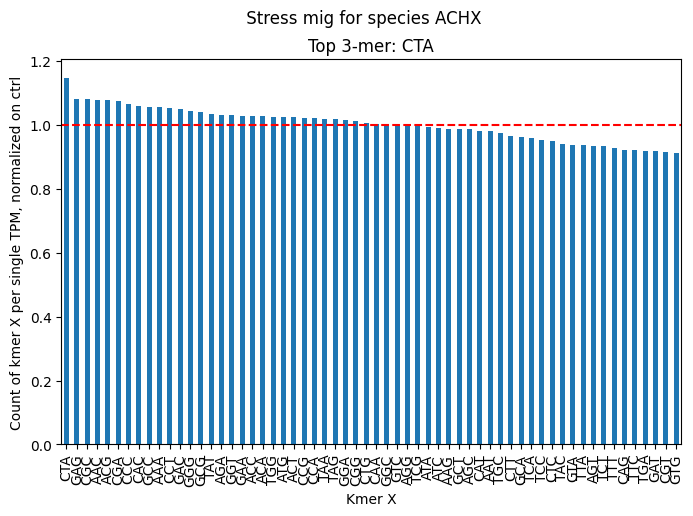

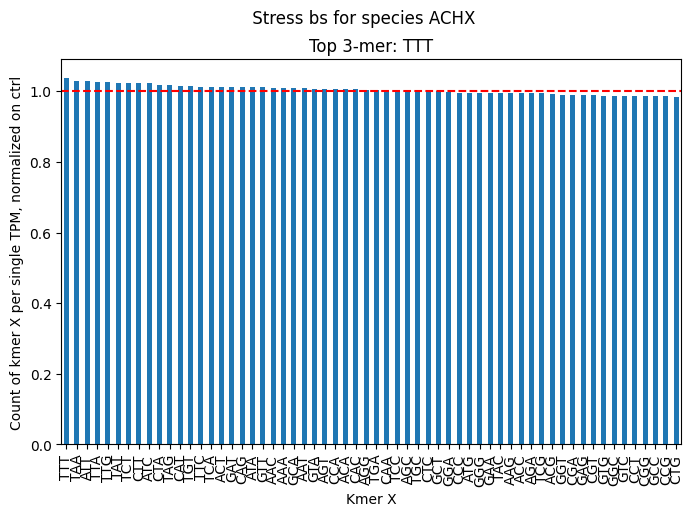

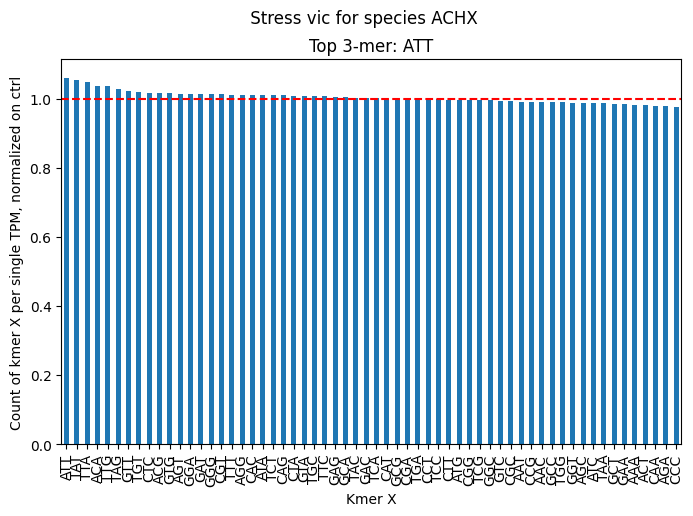

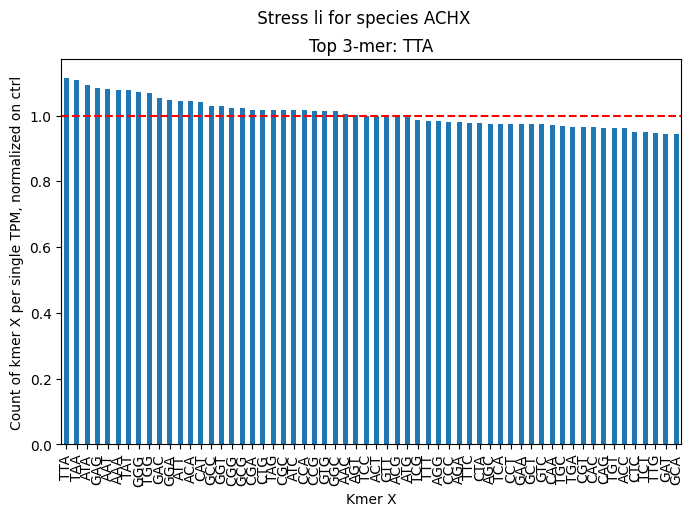

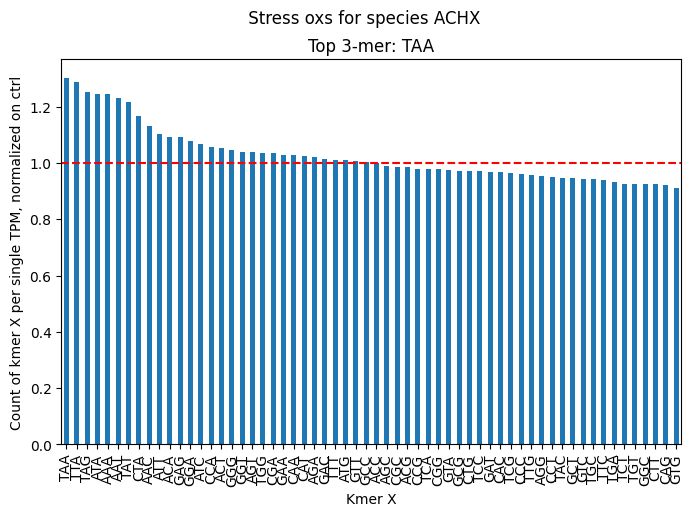

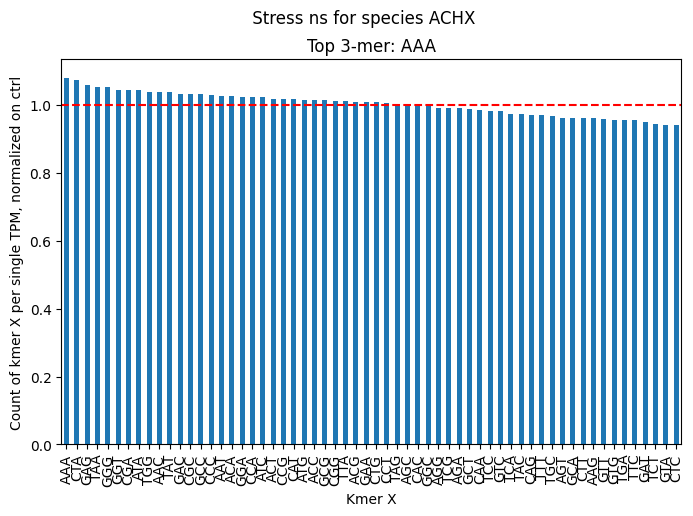

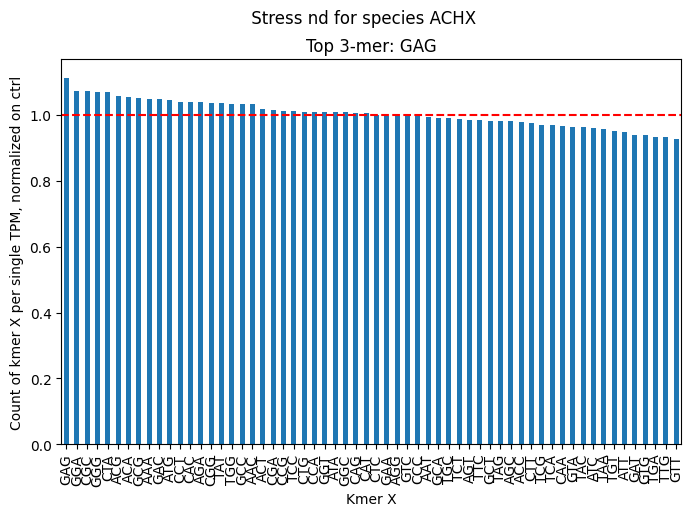

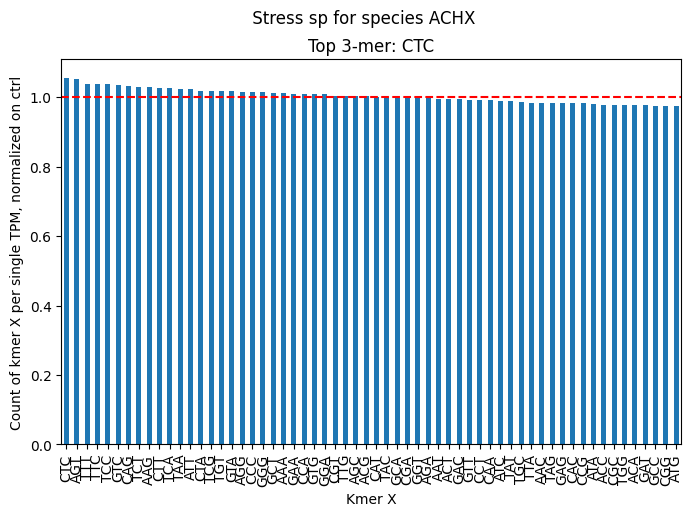

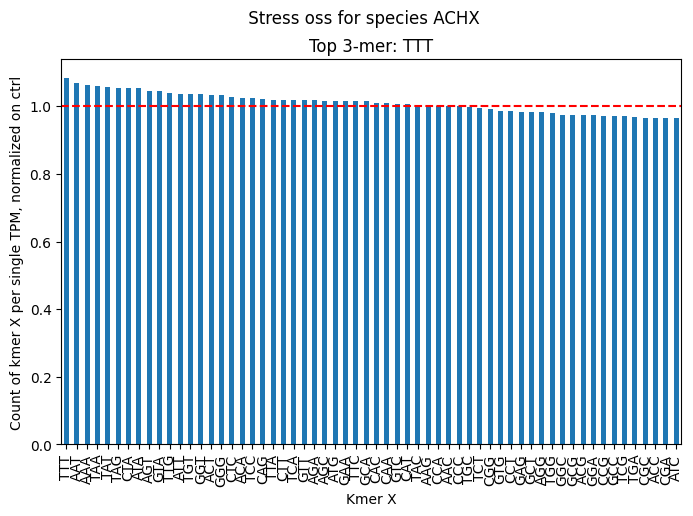

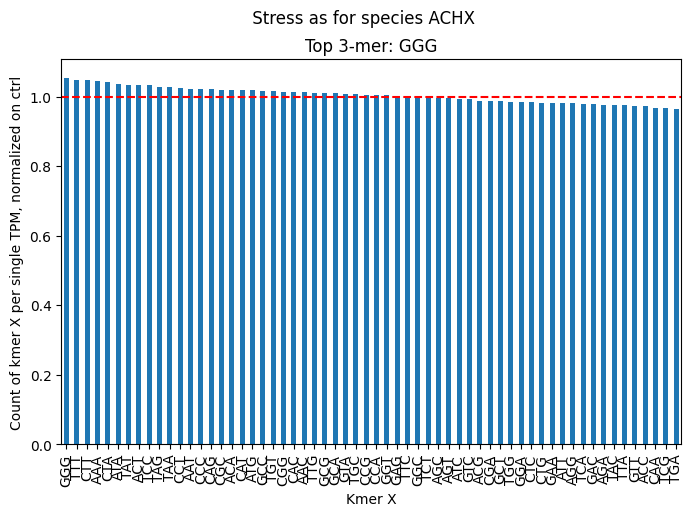

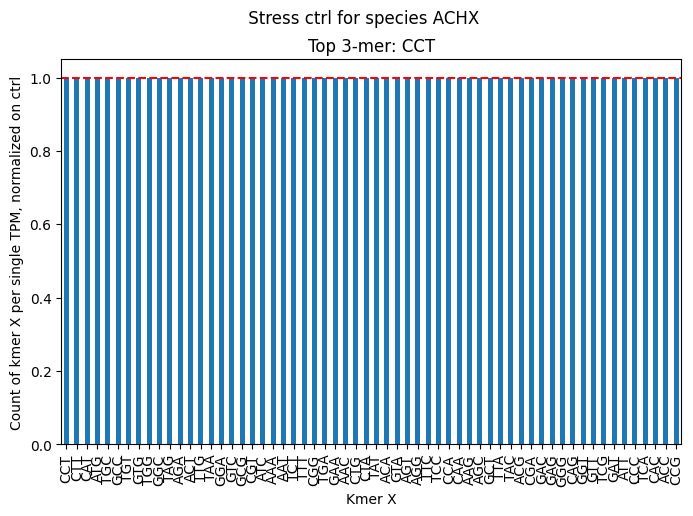

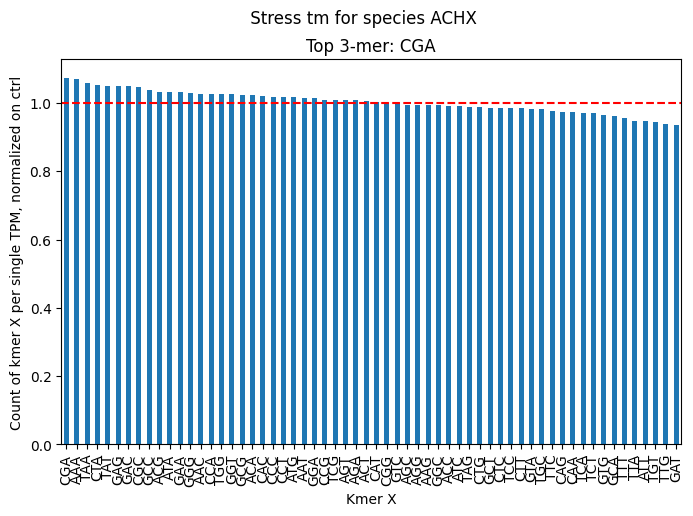

In [21]:

SPEC_ID = 'ACHX'

kmers_normalized = kmers_per_tpm_total[SPEC_ID]

for stress in kmers_normalized.columns:
    # plot top sequences per stress
    tpms = kmers_normalized[stress].sort_values(ascending=False)
    top_seqs = tpms.head(60)

    fig, ax = plt.subplots(1,1, figsize=(8,5))
    top_seqs.plot(kind='bar', ax=ax)
    plt.suptitle(f" Stress {stress} for species {SPEC_ID}")
    plt.axhline(y=1, color='r', linestyle='--')
    plt.title(f"Top {K}-mer: {top_seqs.index[0]}")
    plt.ylabel('Count of kmer X per single TPM, normalized on ctrl')
    plt.xlabel('Kmer X')
    plt.show()





# GC Counting

Percentage of G and C in relation to the full sequence for each species in each condition.

In [108]:

gc_per_tpm_total = {}

for spec_id in tqdm(merged_data['species_id'].unique()):
    species_df = merged_data[merged_data['species_id'] == spec_id]

    stress_conditions = list(set([col.split("_")[0] for col in species_df.columns if 'tpm' in col]))

    gcs_per_tpm = {condition : 0 for condition in stress_conditions}

    species_df.apply(lambda row: gc_counts_per_tpm(gcs_per_tpm, row), axis=1)


    gcs_per_tpm = pd.DataFrame(gcs_per_tpm, index=[0])
    gcs_per_tpm = gcs_per_tpm.div(gcs_per_tpm['ctrl'], axis=0) # normalize on ctrl

    gc_per_tpm_total[spec_id] = gcs_per_tpm
    

  0%|          | 0/32 [00:00<?, ?it/s]

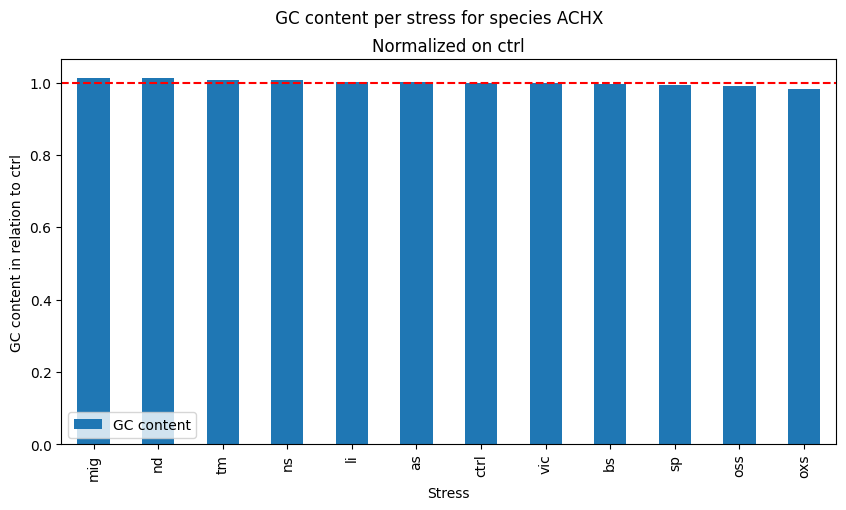

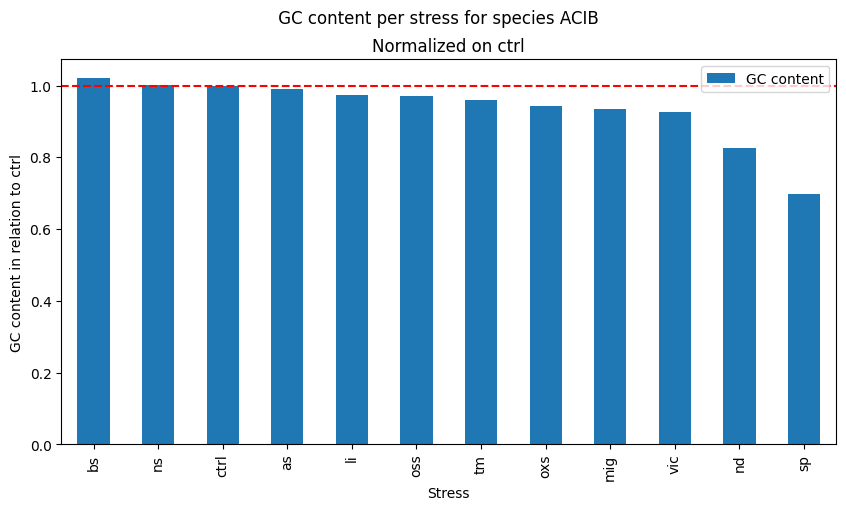

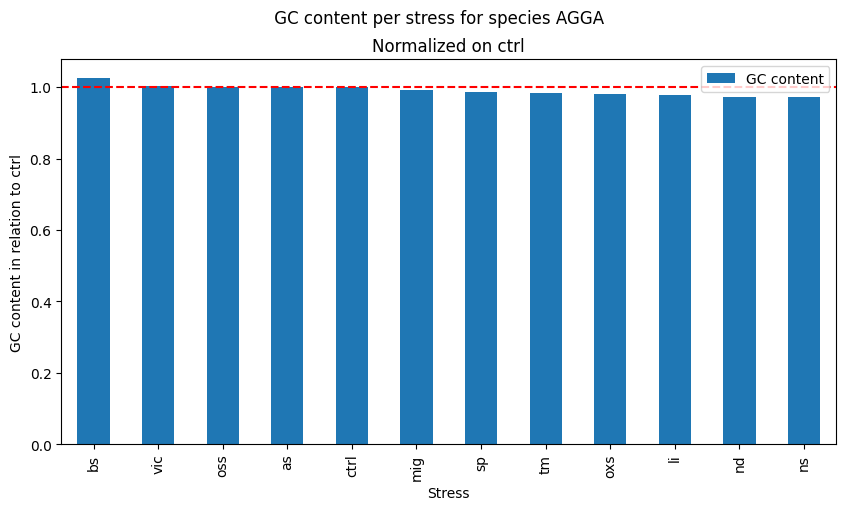

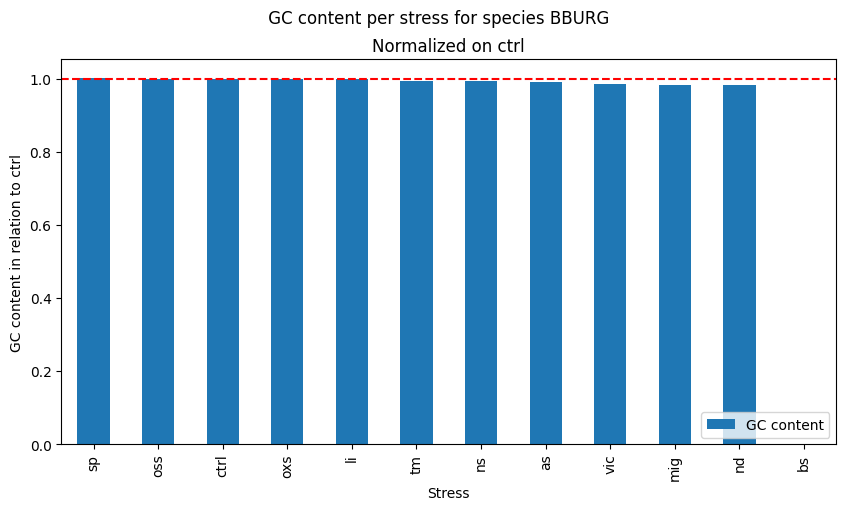

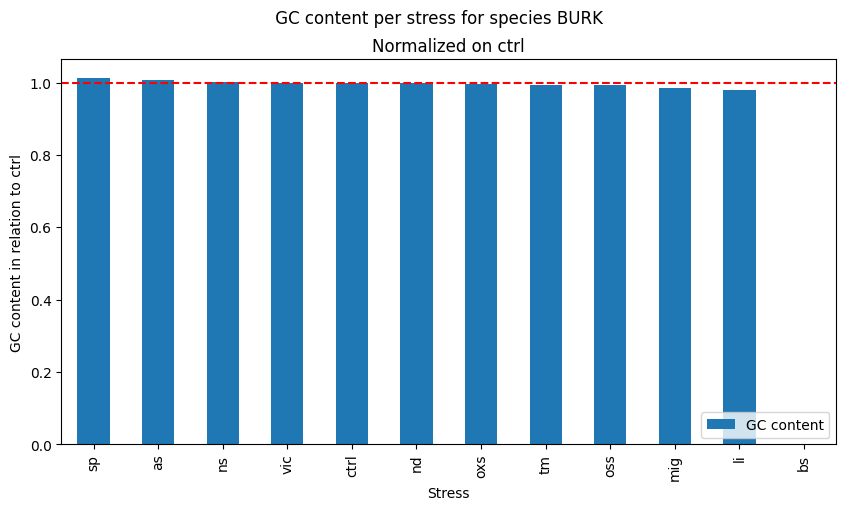

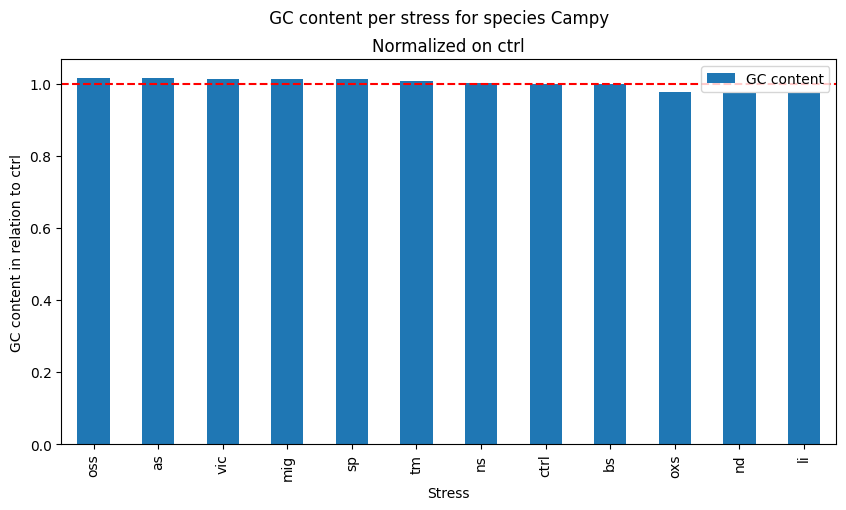

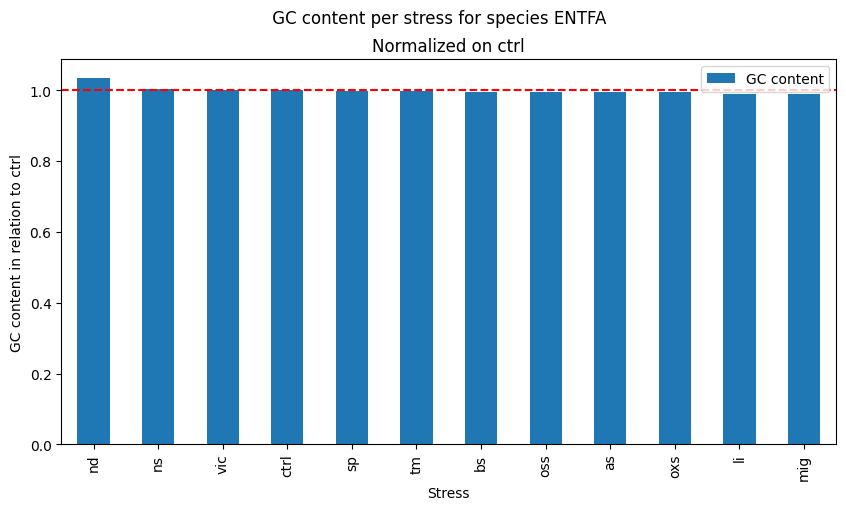

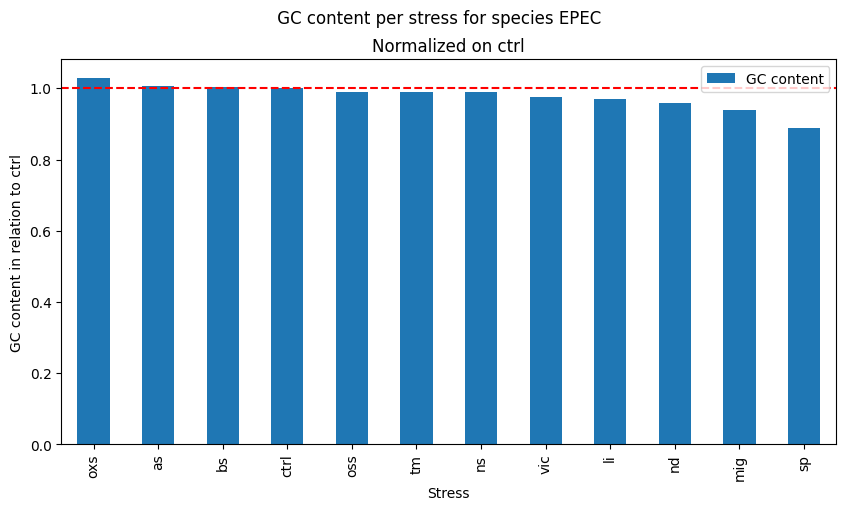

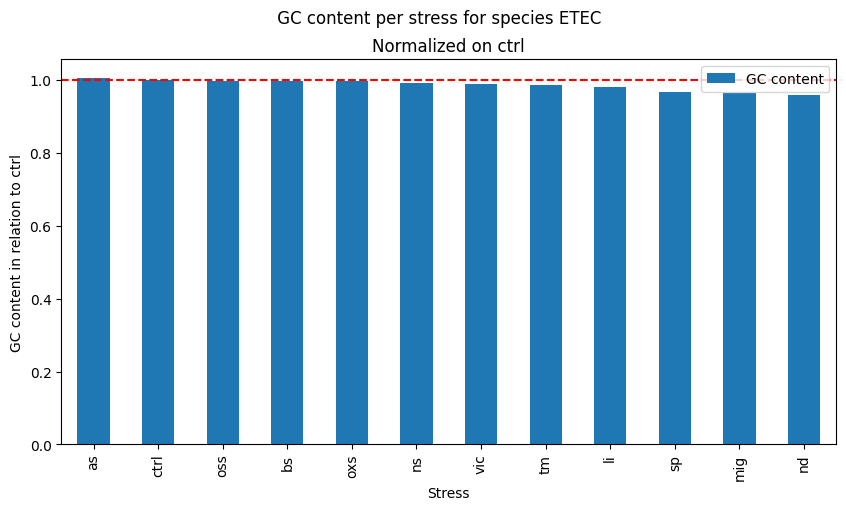

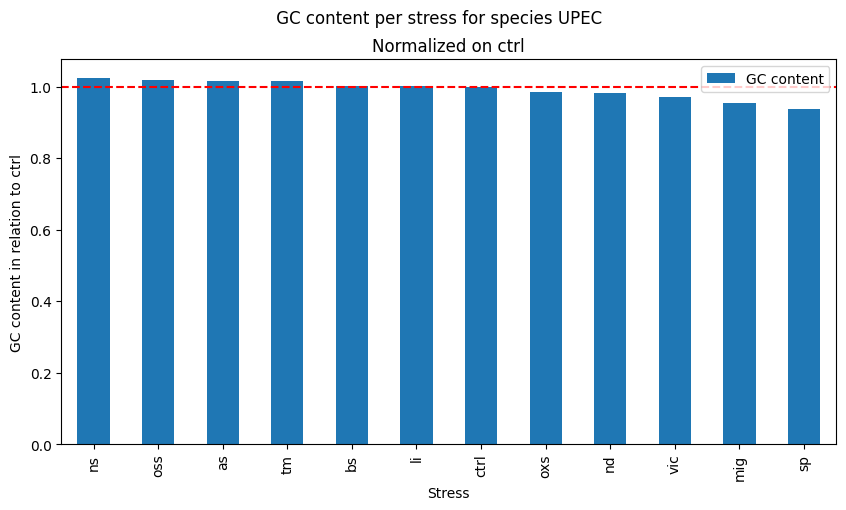

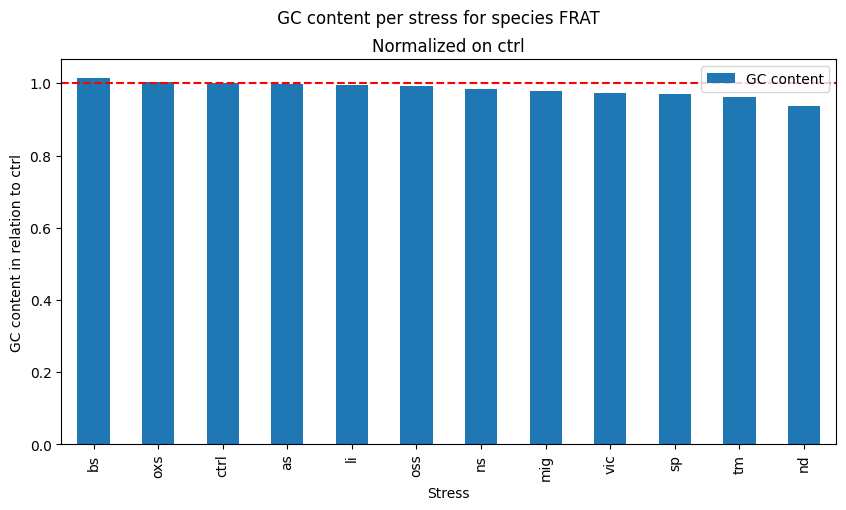

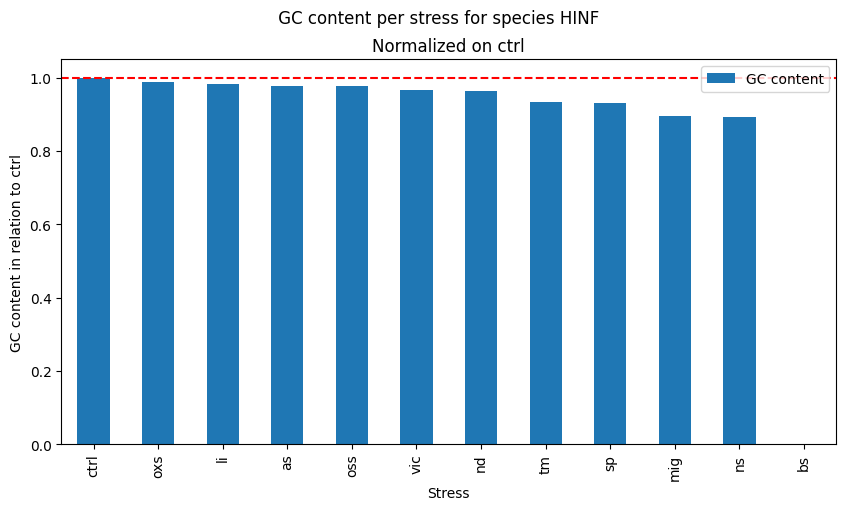

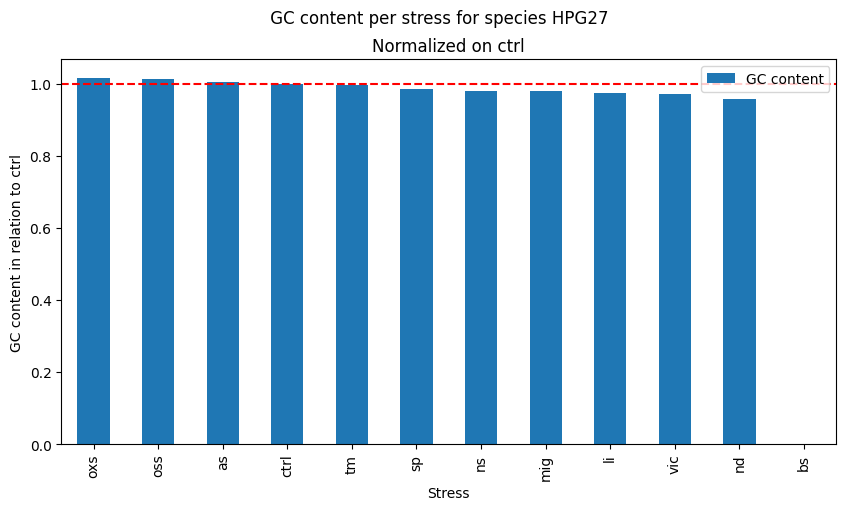

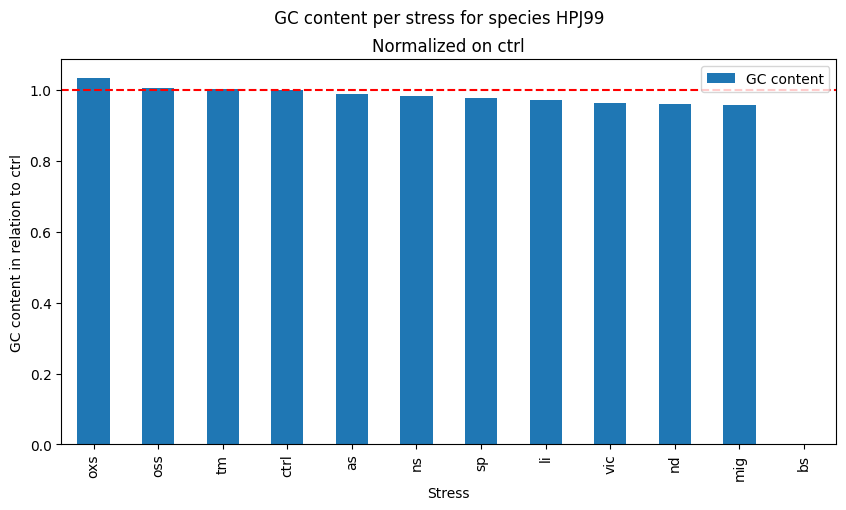

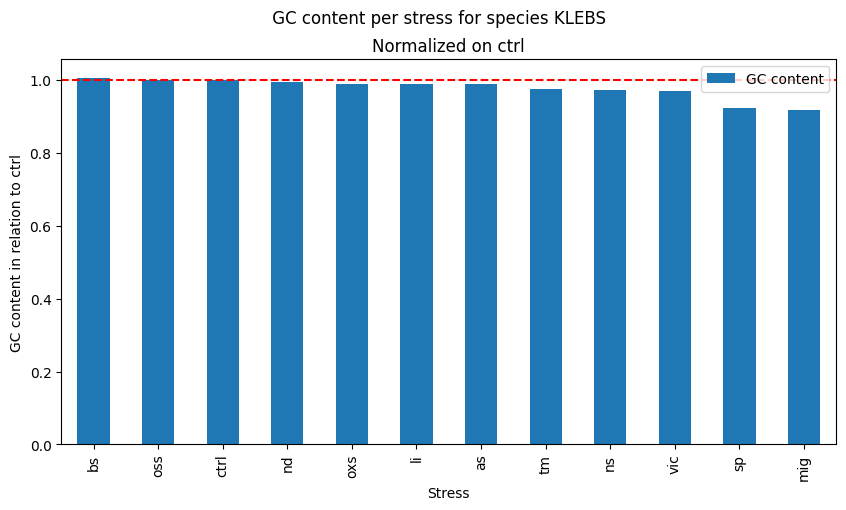

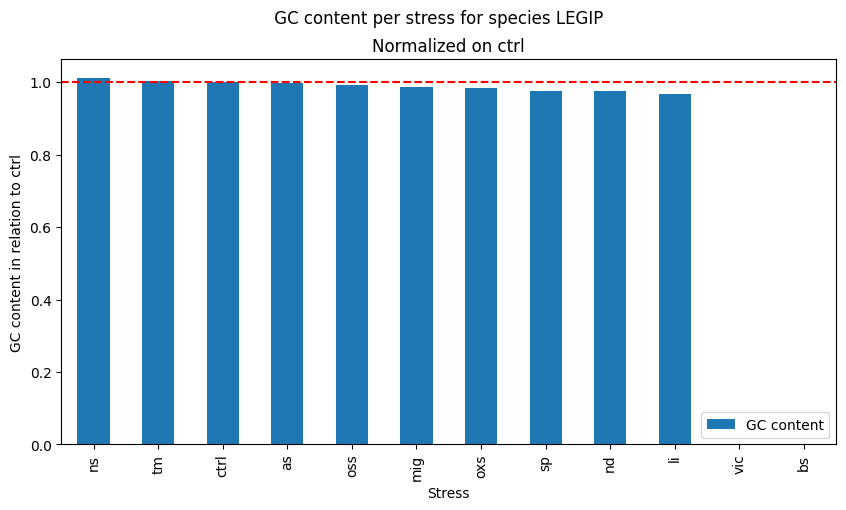

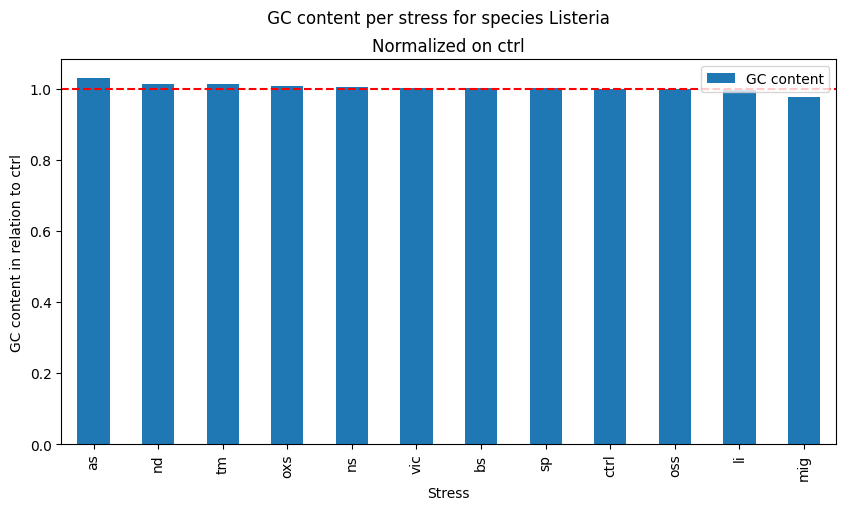

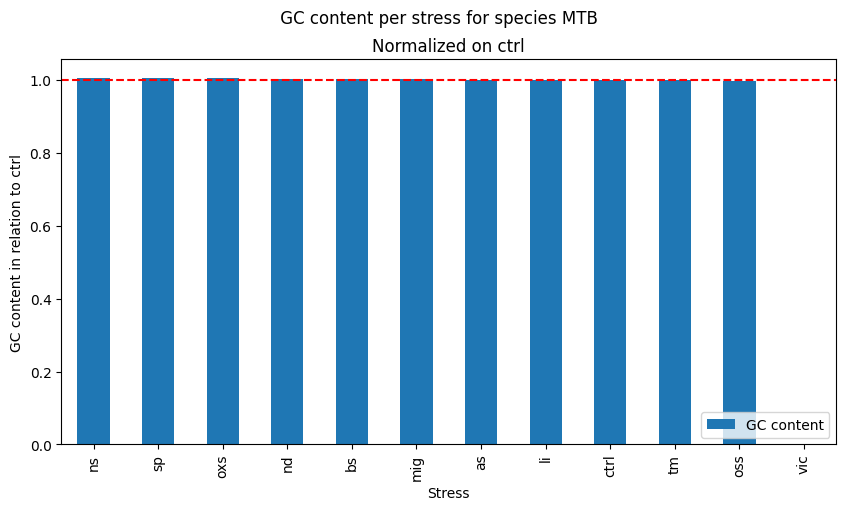

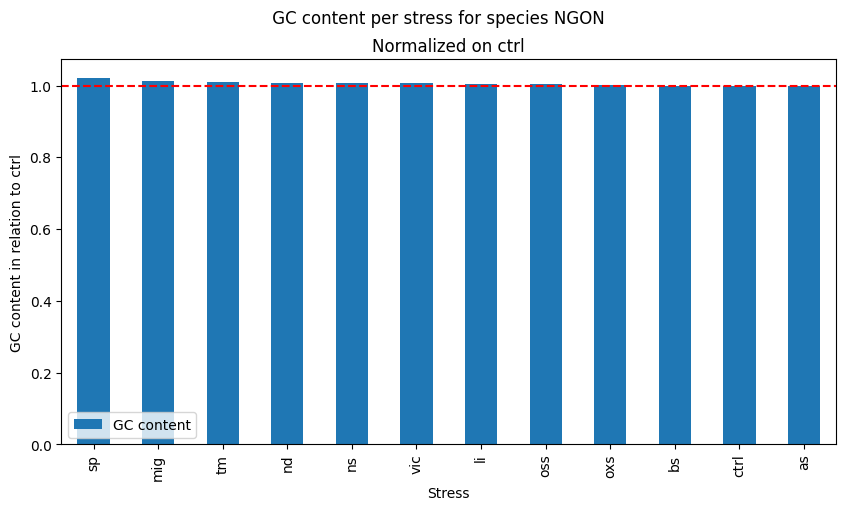

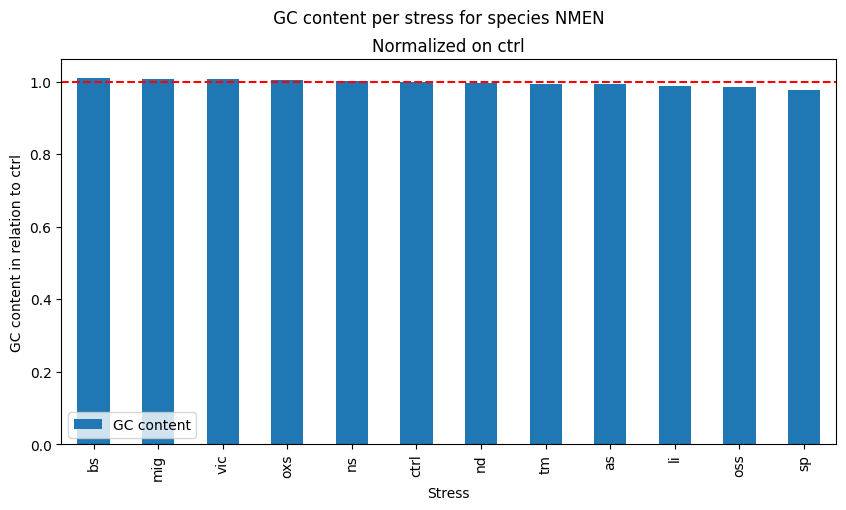

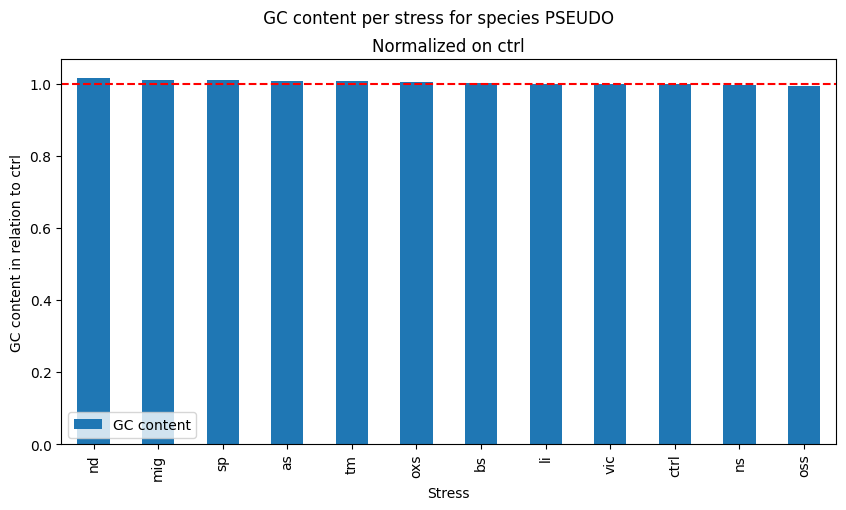

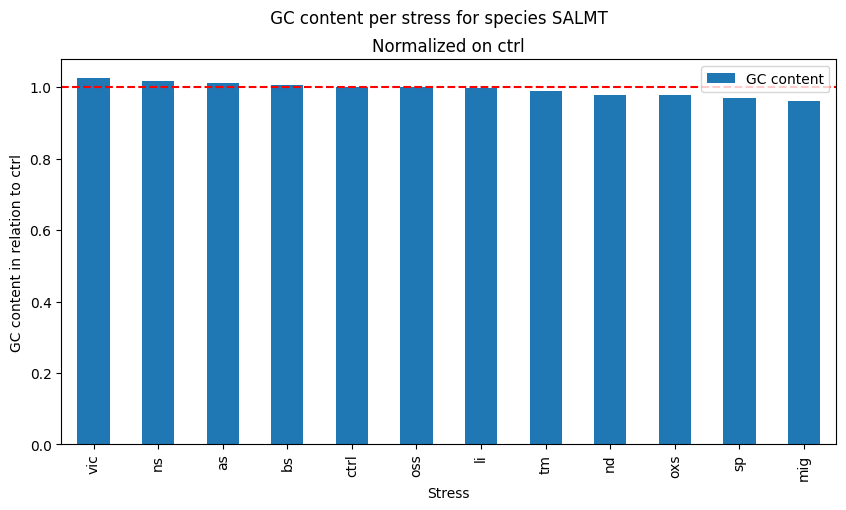

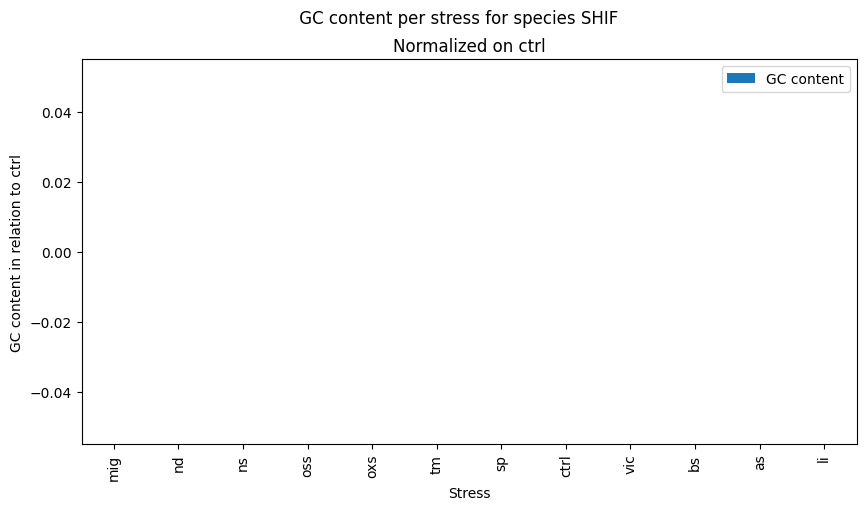

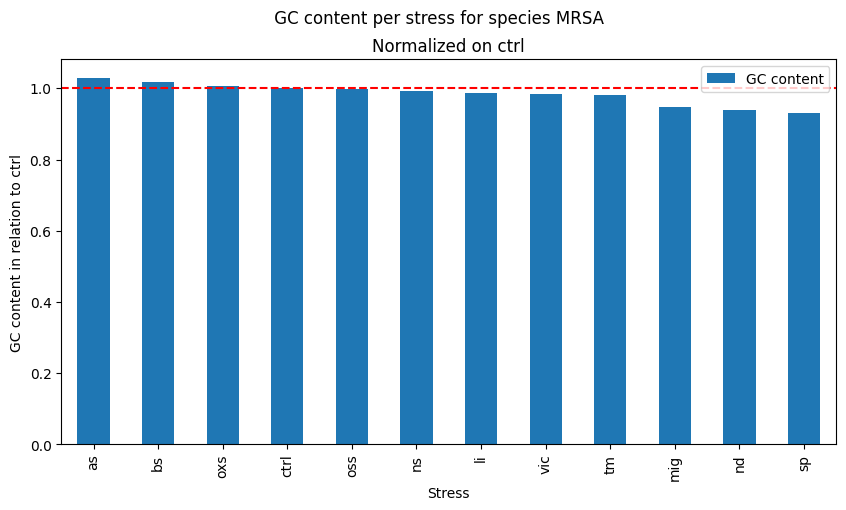

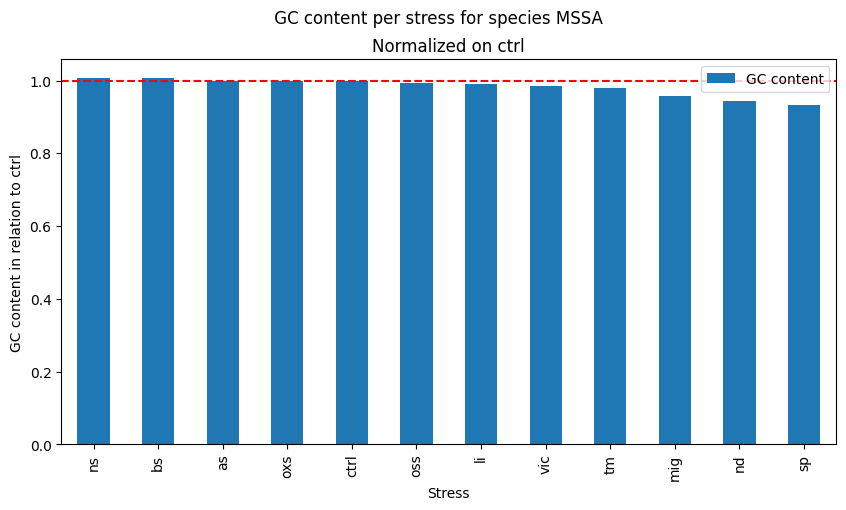

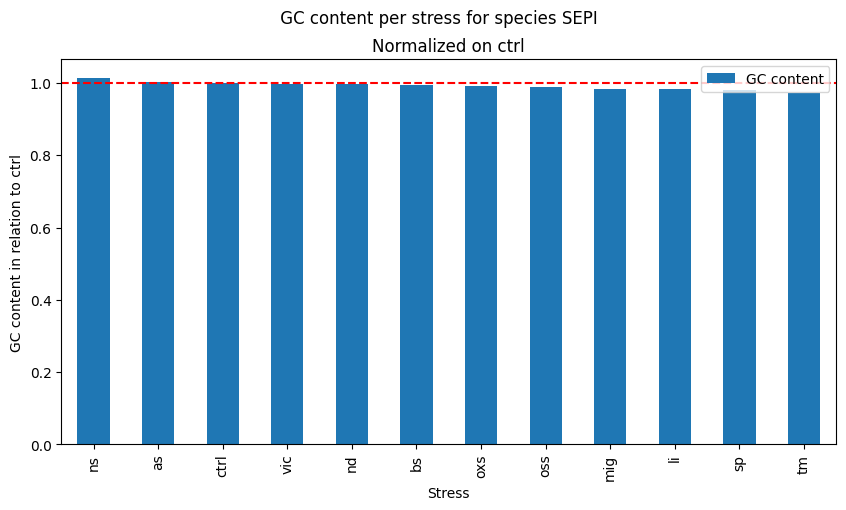

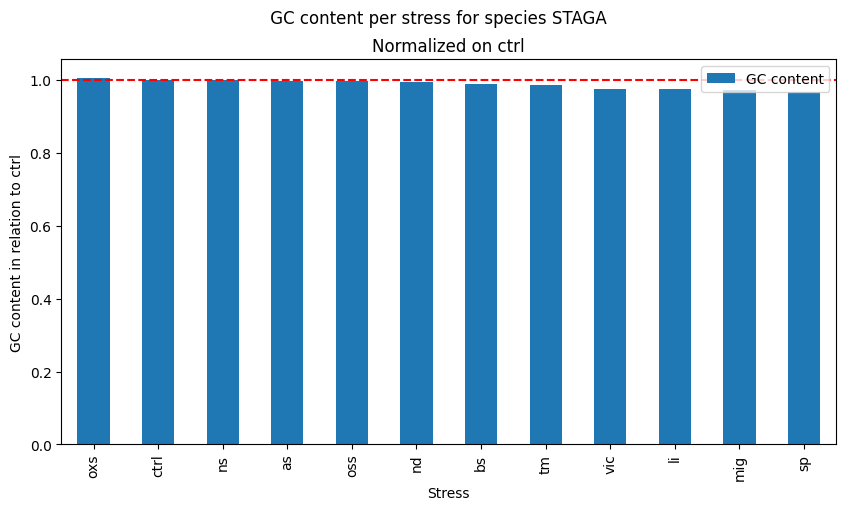

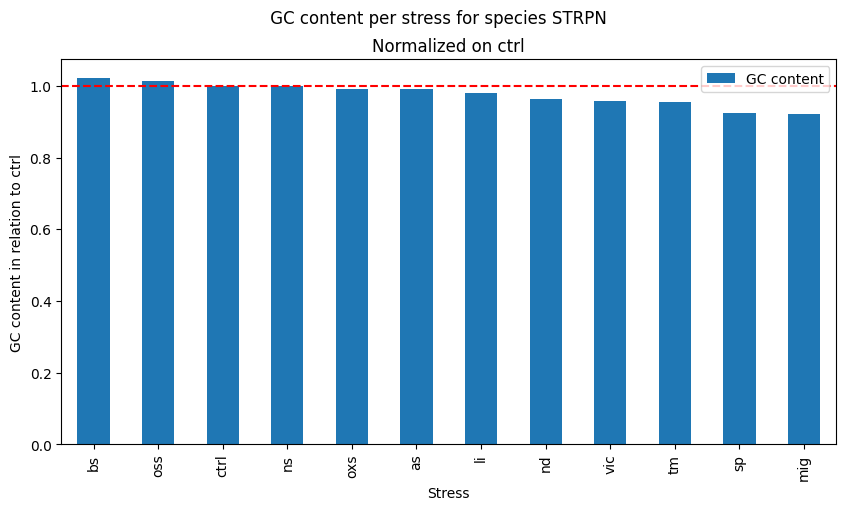

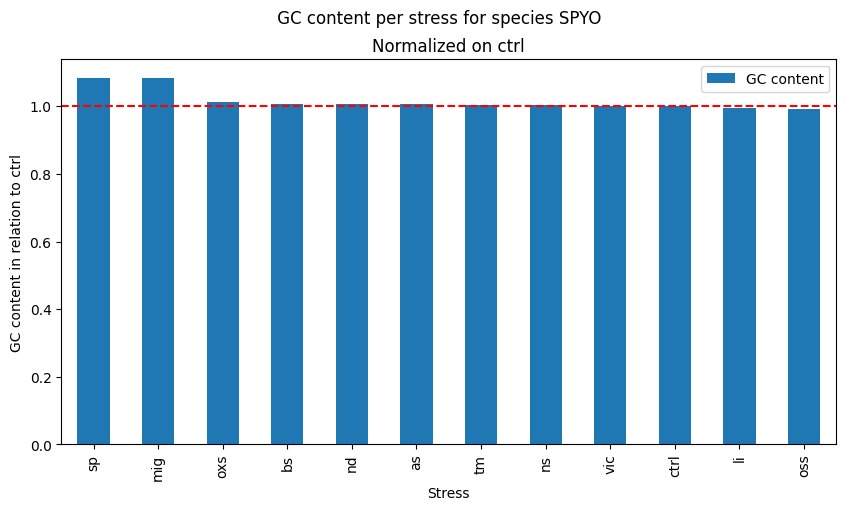

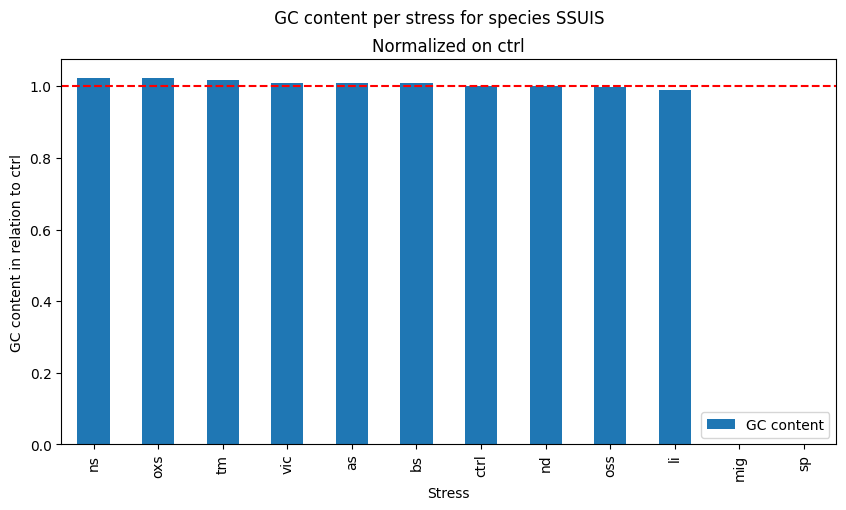

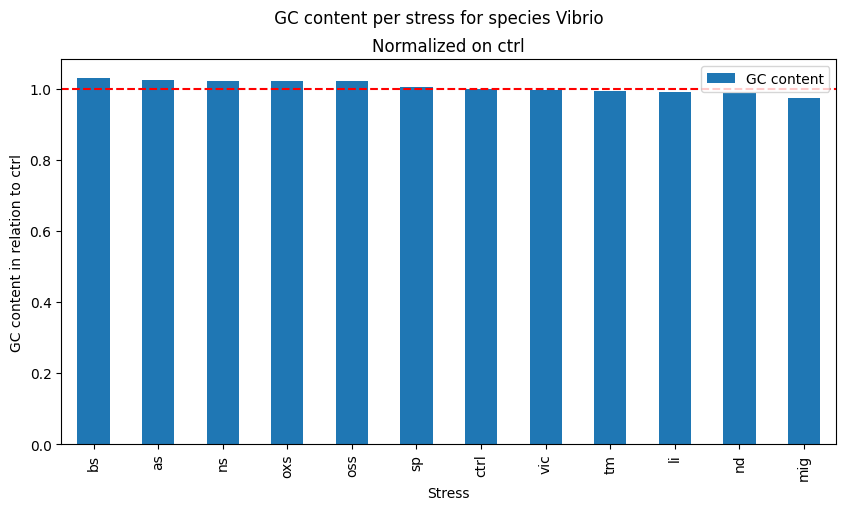

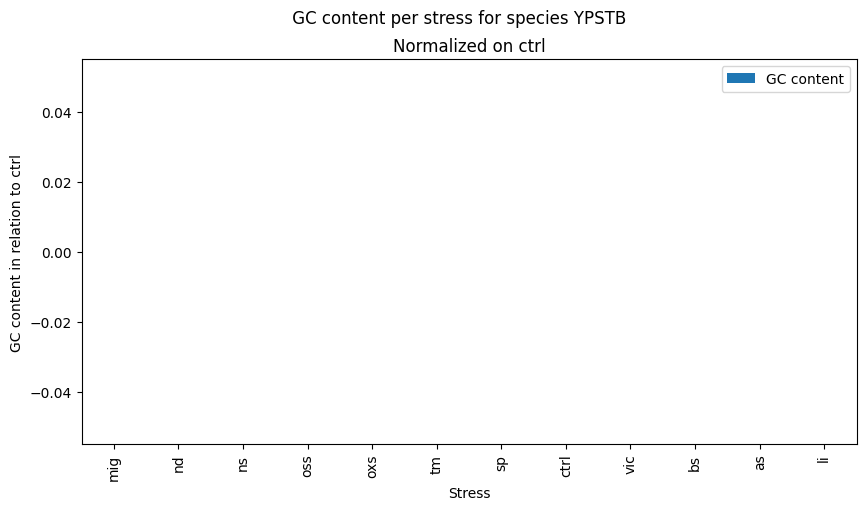

In [109]:
# plot GC content per stress
for spec_id in gc_per_tpm_total:
    gcs_per_tpm = gc_per_tpm_total[spec_id]
    
    gcs_per_tpm = gcs_per_tpm.T
    gcs_per_tpm.columns = ['GC content']
    gcs_per_tpm = gcs_per_tpm.sort_values(by='GC content', ascending=False)

    fig, ax = plt.subplots(1,1, figsize=(10,5))
    gcs_per_tpm.plot(kind='bar', ax=ax)
    plt.axhline(y=gcs_per_tpm.loc['ctrl', 'GC content'], color='r', linestyle='--') # control
    plt.suptitle(f" GC content per stress for species {spec_id}")
    plt.title(f"Normalized on ctrl")
    plt.ylabel('GC content in relation to ctrl')
    plt.xlabel('Stress')
    plt.show()